# DOA algorithm selection
Compares the performance of different DOA algorithms, via:

- Averaged angular error of source azimuth estimation.
- Minimum 2-source angular resolution.

In [32]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

Simulation parameters

In [33]:
# ROOM PARAMETERS

fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 12 # room width
room_y = 20 # room length
stage_x = [1, 11]
stage_y = [12, 18] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air
source_step = 0.1 # resolution of simulation grid (m)

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
array_loc = [6, 11] # x/y location of array - front and center of stage
n_mics = 8 # number of microphones
sep = 0.1 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

### Run Simulations

1st test: single source placed on a grid over the stage.

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_2464/2608165045.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors[i, j] = azimuth_error


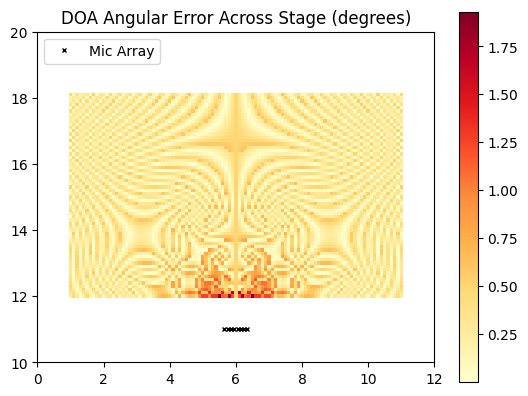

Average azimuth error across stage (deg):  0.2927040077595575
Maximum azimuth error across stage (deg):  1.9281796686983474
Minimum azimuth error across stage (deg):  0.000508915521938416


In [34]:
errors = np.empty(shape=(len(source_x),len(source_y)))
doa_res = 180 # number of candiate angles provided to DOA algorithm - equally spaced between 0 and 180 degrees

for i in range(len(source_x)):
    for j in range(len(source_y)):

        x = source_x[i]
        y = source_y[j]

        # build room, array, and sources
        room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
        room.add_microphone_array(mic_array)

        s1 = [x, y] # 1st source location
        room.add_source(s1, signal=singing, delay=0)
        azimuth_gt = math.atan2(s1[1] - array_loc[1], s1[0] - array_loc[0]) # ground truth azimuth value

        # run simulation
        room.compute_rir()
        room.simulate()

        # define DOA algorithm and compute azimuth
        X = np.array(
            [
                pra.transform.stft.analysis(signal, N, N // 2).T
                for signal in room.mic_array.signals
            ]
        )

        doa = pra.doa.normmusic.NormMUSIC(R, fs, N, c=v_sound, num_src=1, mode='far', azimuth=np.linspace(0, 180, 180)*np.pi/180)
        doa.locate_sources(X, freq_bins=np.arange(1, N))
        azimuth_doa = doa.azimuth_recon

        # compute and store azimuth error
        azimuth_error = abs(azimuth_gt - azimuth_doa)
        errors[i, j] = azimuth_error

errors = errors * 180.0/np.pi # convert errors to degrees

# plot error as a function of location
y, x = np.meshgrid(source_y, source_x)
error_min = np.min(errors)
error_max = np.max(errors)
error_avg = np.mean(errors)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, errors, cmap='YlOrRd', vmin=error_min, vmax=error_max)
ax.plot(mic_array.R[0], mic_array.R[1], 'kx', markersize=3, label="Mic Array")
ax.set_title('DOA Angular Error Across Stage (degrees)')
ax.axis([0, room_x, room_y/2, room_y])
fig.gca().set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax)
plt.legend(loc="upper left")
plt.show()

# output SIR stats
print("Average azimuth error across stage (deg): ", error_avg)
print("Maximum azimuth error across stage (deg): ", error_max)
print("Minimum azimuth error across stage (deg): ", error_min)

2nd test: identification of two separate sources placed increasingly close together, directly in front of the array